### The note book where I will develop the code to collate port information and produce fits

In [33]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

### collect data from files and load

In [15]:
def collate_ports(path_array):
    '''
    Collect individual ports and apply the respective cuts to save space.

    Args:
        path_array          :           an array of folder paths to h5 files
                                        respective of the multiple ports

    
    Returns:
        array               :           output of collective ports
    '''

    for i in range(len(path_array)):
        print("Porting {}".format(path_array[i]))
        if (i==0):
            tracks = (func.load_data(path_array[i]))[0]
        else:
            nu_tracks = (func.load_data(path_array[i]))[0]
            print("Tracks: {}".format(func.len_events(nu_tracks)))
            # multiply the events numbers to avoid overlap
            nu_tracks['event'] = nu_tracks['event'] * (i+1)
            tracks = tracks.append(nu_tracks)

        print("Done! Tracks available: {}".format(func.len_events(tracks)))
    
    return tracks

def positron_ports(path_array):
    '''
    Collect positron events from multiple ports.
    Bespoke, use with care.
    '''

    for i in range(len(path_array)):
        print("Loading positrons from {}".format(path_array[i]))
        if (i==0):
            posi = func.positron_scraper(path_array[i])
            # multiply the event numbers to match track values
            posi['event_id'] = posi['event_id'] * ((i+1)*2)
        else:
            nu_posi = func.positron_scraper(path_array[i])
            print("Positron events: {}".format(func.len_events(nu_posi, tag = 'event_id')))
            # multiple the event numbers to avoid overlap, the *2 is to match it with the tracking values
            nu_posi['event_id'] = nu_posi['event_id'] * ((i+1)*2)
            posi = posi.append(nu_posi)
        print("Port finished! Tracks available: {}".format(func.len_events(posi, tag = 'event_id')))
    
    return posi


In [3]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = collate_ports(folder_paths)

Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973


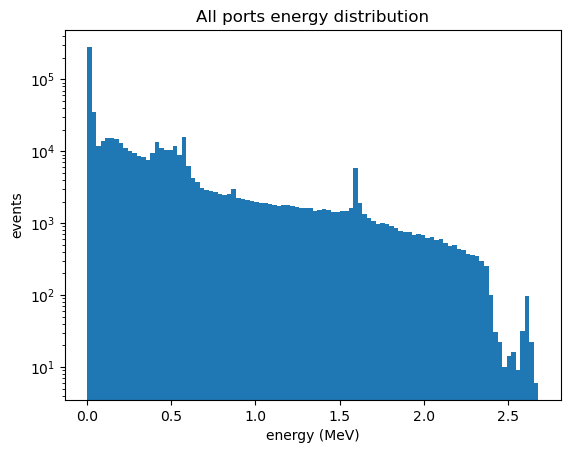

In [11]:
func.plot_hist(full_tracks, binning = 100, title='All ports energy distribution')

In [12]:
# satellite merge
low_e_tracks = func.remove_low_E_events(full_tracks)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.25 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.55 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.78 %
Absolute Cut efficiency:
Efficiency: 7.61 %


4098


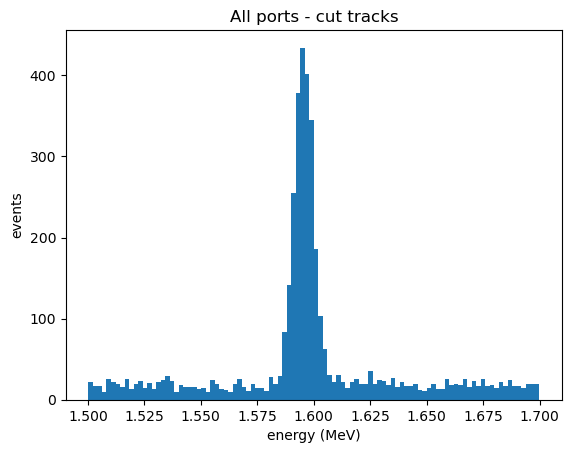

In [13]:
func.plot_hist(cut_tracks[0], binning = 100, title='All ports - cut tracks', log = False)
print(func.len_events(cut_tracks[0]))

In [7]:
eblob_tracks = cut_tracks[0][(cut_tracks[0]['eblob2'] > 0.2)]

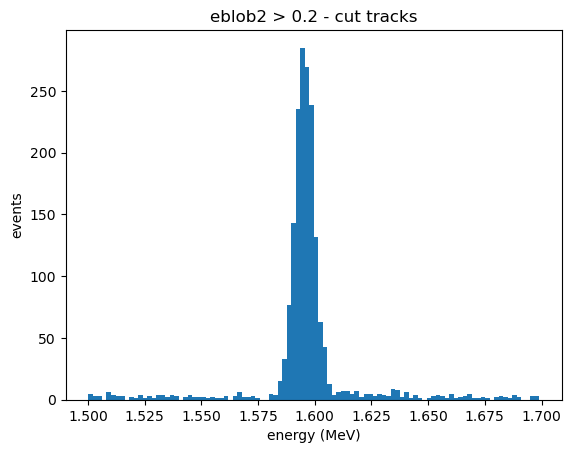

In [31]:
func.plot_hist(eblob_tracks, binning = 100, title='eblob2 > 0.2 - cut tracks', log = False)

### But now, lets create this with only positron events. How annoying!

In [16]:
# find positron events per port
pos_events = positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


### collect positron events from our track data

In [17]:
# double checking event numbers
display(pos_events)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
302,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1182,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
1829,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571950,12181188,55,e+,False,53,-317.644165,122.913124,780.973267,2.805562,-227.563492,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153534,conv,annihil
572070,12181194,29,e+,False,27,388.389008,145.365875,1089.239014,0.848894,388.548676,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
573711,12181302,91,e+,False,87,210.304977,-88.572311,528.882324,2.638315,209.844193,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648548,conv,annihil
574540,12181368,34,e+,False,32,366.878693,391.280914,1094.120483,0.133110,365.349640,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


In [18]:
display(cut_tracks[0])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
107,5080086,0,1.683154,324.712905,75,7056,1,-240.325,-178.325,1037.969888,...,1063.079569,-217.390057,-41.463176,1044.619150,0.425738,0.077629,0.0,14.875000,14.500000,13.632267
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,725.763938,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,464.605430,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,496.417735,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316
1054,1740082,0,1.619501,331.972634,74,7845,1,-10.325,-338.325,191.247312,...,259.525777,85.790312,-134.035423,305.482562,0.441276,0.031332,0.0,14.714286,14.133333,13.536416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,1051.595740,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,892.940698,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,365.745065,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209
658904,12180888,0,1.596929,178.966898,57,6689,1,169.675,129.675,1087.524900,...,1153.339031,292.144829,210.538713,1121.916075,0.362043,0.032287,0.0,14.222222,14.333333,13.040278


In [23]:
# select only events in which events have positrons
sig_data = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
bck_data = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

In [21]:
display(sig_data)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,725.763938,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,464.605430,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,496.417735,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316
1300,1740272,0,1.585759,96.603199,52,7973,1,-188.325,53.675,411.501398,...,436.442081,-118.512245,62.872010,445.278366,0.451501,0.414708,0.0,13.166667,12.833333,13.914674
1637,1740538,0,1.601273,193.444398,49,7205,1,-103.325,-249.325,453.332480,...,481.087655,-91.482329,-242.297144,508.823884,0.589608,0.299892,0.0,14.090909,14.000000,13.106973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658476,14820972,0,1.599220,234.859839,58,6300,1,141.675,-246.325,841.829888,...,901.553124,147.839494,-233.666790,870.039122,0.537754,0.368148,0.0,14.714286,14.222222,14.370326
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,1051.595740,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,892.940698,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,365.745065,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209


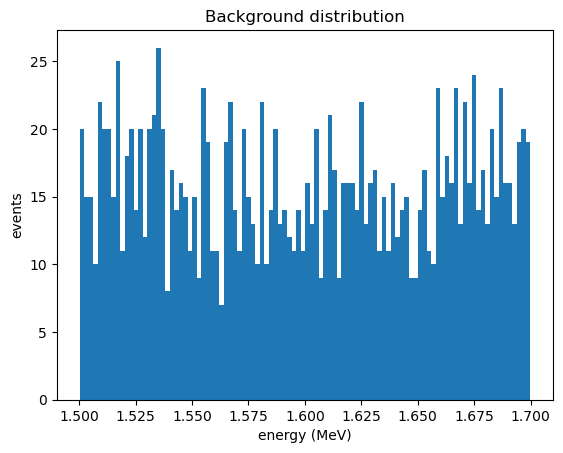

In [31]:
func.plot_hist(bck_data, binning = 100, title='Background distribution', log = False)

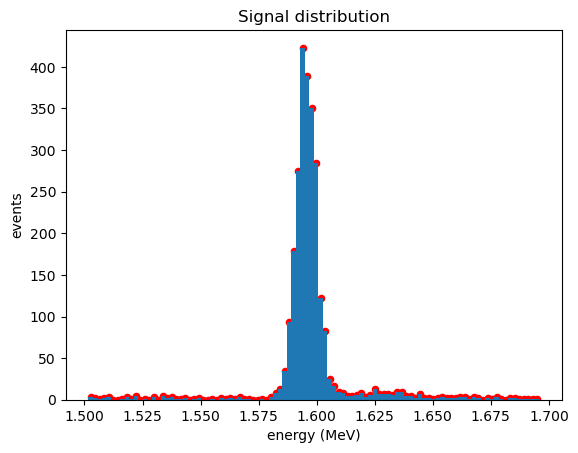

In [30]:
hist, edges, patches = func.plot_hist(sig_data, binning = 100, title='Signal distribution', log = False, data = True)

centres = shift_to_bin_centers(edges)
plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [35]:
# fit the signal function to our data here
def sig_func(x, ns, a, mu, sigma, C1, C2):
    # move this to functions.py (its already there, just for importing purposes this is easier)    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# p0 is apriori
p0 = ([1, 400, 1.58, 0.3, 4.5, 2])
fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']


popt, pcov = curve_fit(sig_func, centres, hist, p0, maxfev = 500000)

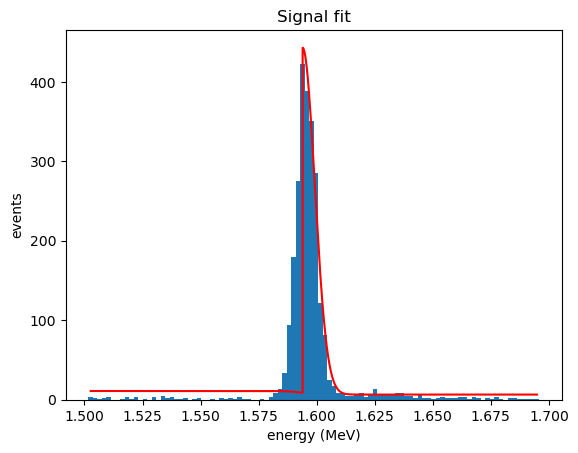

        Fitting output      
B1: 2.8462 ± 1.4533
A: 37410.1902 ± 535351463.6152
mu: 1.5939 ± 0.0030
sigma: 0.0052 ± 0.0016
C1: 0.7904 ± 1.3217
C2: 2.2776 ± 2.3195


0

In [40]:
plot_fit(sig_func, centres, popt, fit_labels)
func.plot_hist(sig_data, binning = 100, title='Signal fit', log = False)
plt.show()
print_parameters(popt, pcov, fit_labels)